In [ ]:
from konlpy.tag import Okt
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 데이터 로드
df = pd.read_csv("../01_데이터수집/data/finance_data.csv").drop_duplicates(subset=["kor_sentence"])
df["labels"] = df["labels"].replace({"neutral": 0, "positive": 1, "negative": 2})

okt = Okt()

def extract_tokens(text):
    tokens = okt.pos(text, stem=True)
    return [word for word, pos in tokens if pos in ["Noun", "Adjective", "Verb"] and len(word) > 1]

# 긍정 / 부정 문장 분리
pos_sentences = df[df["labels"] == 1]["kor_sentence"]
neg_sentences = df[df["labels"] == 2]["kor_sentence"]

# 단어 수집
pos_words = []
neg_words = []

for s in pos_sentences:
    pos_words.extend(extract_tokens(s))
for s in neg_sentences:
    neg_words.extend(extract_tokens(s))

# 빈도 계산 및 점수 계산
pos_counter = Counter(pos_words)
neg_counter = Counter(neg_words)
all_words = set(pos_counter) | set(neg_counter)

scores = {}
for w in all_words:
    pf, nf = pos_counter.get(w, 0), neg_counter.get(w, 0)
    scores[w] = round((pf - nf) / (pf + nf + 1e-5), 4)

# 상위 단어 출력
# top_pos = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:30]
# top_neg = sorted(scores.items(), key=lambda x: x[1])[:30]

top_pos = sorted(pos_counter.items(), key=lambda x: x[1], reverse=True)[:30]
top_pos_with_score = [(word, count, scores[word]) for word, count in top_pos]

top_neg = sorted(neg_counter.items(), key=lambda x: x[1], reverse=True)[:30]
top_neg_with_score = [(word, count, scores[word]) for word, count in top_neg]

print("Top 30 Positive Words:")
print(top_pos)

print("\nTop 30 Negative Words:")
print(top_neg)

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_8591/10011896.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["labels"] = df["labels"].replace({"neutral": 0, "positive": 1, "negative": 2})


Top 30 Positive Words:
[('하다', 1340), ('유로', 369), ('증가', 332), ('있다', 303), ('핀란드', 275), ('되다', 215), ('늘다', 202), ('회사', 193), ('매출', 152), ('이익', 146), ('밝히다', 142), ('영업', 139), ('이다', 112), ('서비스', 105), ('계약', 105), ('기간', 104), ('되어다', 88), ('그룹', 86), ('체결', 81), ('사업', 76), ('업체', 76), ('시장', 74), ('순이익', 71), ('기록', 68), ('비다', 64), ('손실', 63), ('같다', 62), ('따르다', 61), ('대한', 60), ('제공', 60)]

Top 30 Negative Words:
[('하다', 470), ('유로', 203), ('감소', 159), ('핀란드', 143), ('이익', 121), ('영업', 99), ('되다', 94), ('매출', 85), ('있다', 76), ('손실', 75), ('회사', 74), ('늘다', 74), ('기간', 70), ('하락', 60), ('비다', 60), ('이다', 59), ('밝히다', 49), ('순이익', 43), ('떨어지다', 41), ('해고', 40), ('직원', 38), ('기록', 34), ('헬싱키', 33), ('그룹', 32), ('발표', 32), ('명의', 29), ('같다', 29), ('오늘', 28), ('업체', 28), ('되어다', 28)]


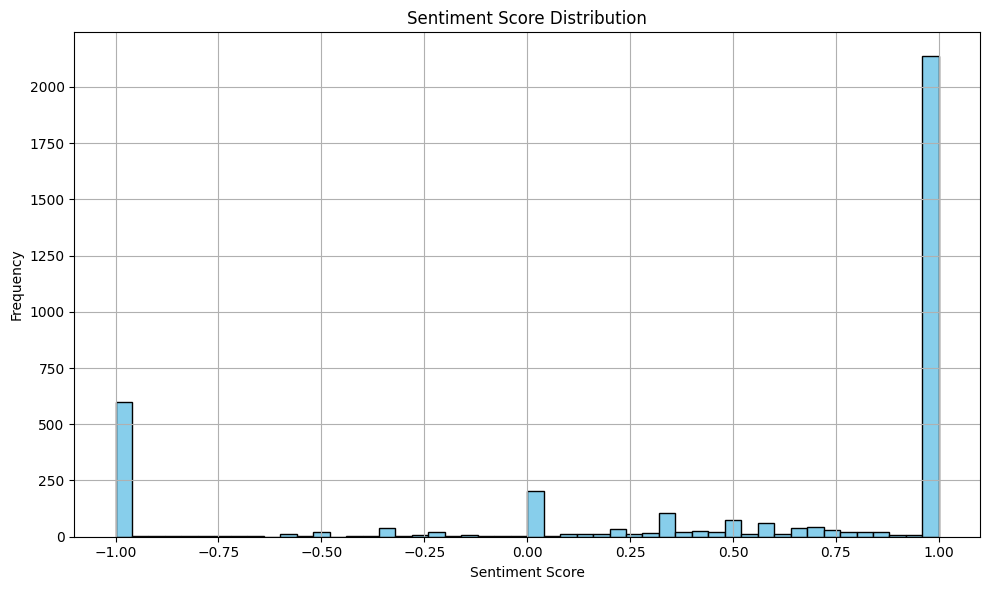

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(list(scores.values()), bins=50, color='skyblue', edgecolor='black')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()